In [1]:
from csv import DictReader

with open('schweidtmann_train.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    _c_tr = [r for r in reader]
csv_file.close()
comp_train = []
for c in _c_tr:
    if c['Meas RON'] != 'n.a.':
        comp_train.append(c)

with open('schweidtmann_test.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    _c_te = [r for r in reader]
csv_file.close()
comp_test = []
for c in _c_te:
    if c['Meas RON'] != 'n.a.':
        comp_test.append(c)

smiles_train = [c[' SMILES'] for c in comp_train]
targets_train = [[float(c['Meas RON'])] for c in comp_train]
smiles_test = [c[' SMILES'] for c in comp_test]
targets_test = [[float(c['Meas RON'])] for c in comp_test]

In [2]:
from graphchem import CompoundOperator

co = CompoundOperator()
train_loss, valid_loss = co.train(
    smiles_train, targets_train, verbose=10,
    valid_size=0.33,
    valid_patience=128,
    batch_size=32,
    epochs=2048,
    random_state=None,
    shuffle=True,
    lr=0.001,
    lr_decay=0.0,
    model_config={
        'n_messages': 2,
        'n_hidden': 1,
        'hidden_dim': 256,
        'dropout': 0.0
    }
)

Epoch: 0 | Train Loss: 1101.493558995864 | Valid Loss: 513.2182006835938
Epoch: 10 | Train Loss: 319.8892835729262 | Valid Loss: 231.93682861328125
Epoch: 20 | Train Loss: 286.3207110236673 | Valid Loss: 187.60655212402344
Epoch: 30 | Train Loss: 279.5423718620749 | Valid Loss: 185.87777709960938
Epoch: 40 | Train Loss: 172.00546264648438 | Valid Loss: 146.4354248046875
Epoch: 50 | Train Loss: 176.40057821834787 | Valid Loss: 108.06889343261719
Epoch: 60 | Train Loss: 138.68660668765799 | Valid Loss: 102.27093505859375
Epoch: 70 | Train Loss: 156.19192325367646 | Valid Loss: 106.76914978027344
Epoch: 80 | Train Loss: 104.72237171846278 | Valid Loss: 90.54165649414062
Epoch: 90 | Train Loss: 109.47798964556526 | Valid Loss: 85.76237487792969
Epoch: 100 | Train Loss: 80.76493364221909 | Valid Loss: 81.13282012939453
Epoch: 110 | Train Loss: 67.84473374310662 | Valid Loss: 66.96480560302734
Epoch: 120 | Train Loss: 70.82362634995404 | Valid Loss: 60.083709716796875
Epoch: 130 | Train Loss

In [3]:
from sklearn.metrics import mean_absolute_error, r2_score

pred_train = co.use(smiles_train)
pred_test = co.use(smiles_test)
print('MAE Train: {}'.format(
    mean_absolute_error(targets_train, pred_train)
))
print('MAE Test: {}'.format(
    mean_absolute_error(targets_test, pred_test)
))
print('R2 Train: {}'.format(
    r2_score(targets_train, pred_train)
))
print('R2 Test: {}'.format(
    r2_score(targets_test, pred_test)
))


MAE Train: 1.0374609708786011
MAE Test: 6.828510877490044
R2 Train: 0.9954590075743206
R2 Test: 0.8489572785010332


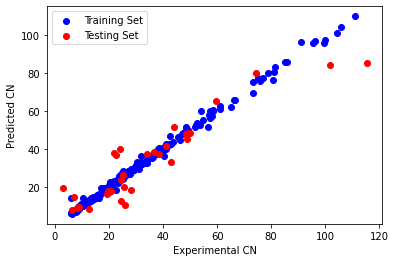

In [4]:
from matplotlib import pyplot as plt

plt.clf()
plt.xlabel('Experimental RON')
plt.ylabel('Predicted RON')
plt.scatter(targets_train, pred_train, color='blue', label='Training Set')
plt.scatter(targets_test, pred_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()

In [5]:
co.save_model('model_ron.pt', 'encoder_ron.enc')

In [6]:
co2 = CompoundOperator()
co2.load_model('model_ron.pt', 'encoder_ron.enc')
pred_train = co2.use(smiles_train)
pred_test = co2.use(smiles_test)
print('MAE Train: {}'.format(
    mean_absolute_error(targets_train, pred_train)
))
print('MAE Test: {}'.format(
    mean_absolute_error(targets_test, pred_test)
))
print('R2 Train: {}'.format(
    r2_score(targets_train, pred_train)
))
print('R2 Test: {}'.format(
    r2_score(targets_test, pred_test)
))

MAE Train: 1.0374609708786011
MAE Test: 6.828510877490044
R2 Train: 0.9954590075743206
R2 Test: 0.8489572785010332


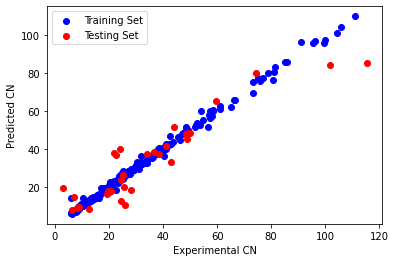

In [7]:
plt.clf()
plt.xlabel('Experimental RON')
plt.ylabel('Predicted RON')
plt.scatter(targets_train, pred_train, color='blue', label='Training Set')
plt.scatter(targets_test, pred_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()